# TTstar benchmarks

First, let's get formalities out of the way.

In [30]:
library(ggplot2)
library(reshape2)
library(repr)

options(repr.plot.width=4, repr.plot.height=3)

In [31]:
# load measured data
#xs <- read.csv('benchmark-1490607733.csv')
#xs <- read.csv('benchmark-1491380156.csv')
#xs <- read.csv('benchmark-1493248450.csv')
xs <- read.csv('benchmark-1493251003.csv')
str(xs)

'data.frame':	840 obs. of  10 variables:
 $ program       : Factor w/ 1 level "bin": 1 1 1 1 1 1 1 1 1 1 ...
 $ inference     : Factor w/ 2 levels "False","True": 2 2 2 2 2 2 2 2 2 2 ...
 $ specialisation: Factor w/ 1 level "False": 1 1 1 1 1 1 1 1 1 1 ...
 $ verification  : Factor w/ 2 levels "False","True": 2 2 2 2 2 2 2 2 2 2 ...
 $ normalisation : Factor w/ 2 levels "False","True": 2 2 2 2 2 2 2 2 2 2 ...
 $ compilation   : Factor w/ 3 levels "","False","True": 1 1 3 3 3 3 3 3 3 3 ...
 $ input_size    : int  NA NA NA NA 1 1 32769 32769 65537 65537 ...
 $ sample_no     : int  0 1 0 1 0 1 0 1 0 1 ...
 $ stage         : Factor w/ 3 levels "csc","execution",..: 3 3 1 1 2 2 2 2 2 2 ...
 $ runtime       : num  0.04952 0.04928 1.46056 1.44594 0.00251 ...


In [32]:
# convert strings "True"/"False" into proper R booleans
bools <- c('inference', 'specialisation', 'verification', 'normalisation', 'compilation')
nas <- xs[,bools] == ""
xs[,bools] <- xs[,bools] == "True"
xs[,bools][nas] <- NA

Next, we build configuration descriptors in the form `$stage-$features`.

There are three stages:
* `ttstar` -- takes TTstar source, emits Scheme source
* `csc` -- compiles Scheme source to native code (via GCC); not present if intepreting
* `execute` -- running the final program
  * either compiled in the `csc` stage
  * or interpreted using `csi` directly from the Scheme source
  
There are features that can be enabled or disabled:
* `i`-nference -- erasure inference + erasure
* `s`-pecialisation -- erasure polymorphism
* `v`-erification -- final type check of the fully explicitly erasure-annotated program
* `n`-ormalisation -- NF-reduction of the final program
* `c`-ompilation -- running `csc`, the Scheme compiler

If the flag `c` is not present, the Scheme program is interpreted using `csi`.

In [33]:
# make config strings
tr <- xs

block <- xs[,bools]
block[is.na(block)] <- F

tr$config <- paste(as.character(tr$stage), "-", sep="")
for (col in bools) {
    tr$config[block[,col]] <- paste(tr$config[block[,col]], substr(col, 1, 1), sep="")
}
tr$config <- factor(tr$config)

## Stage: TTstar

We can clearly see that while normalisation and verification take just a little bit of time, erasure inference takes the bulk of processing time.

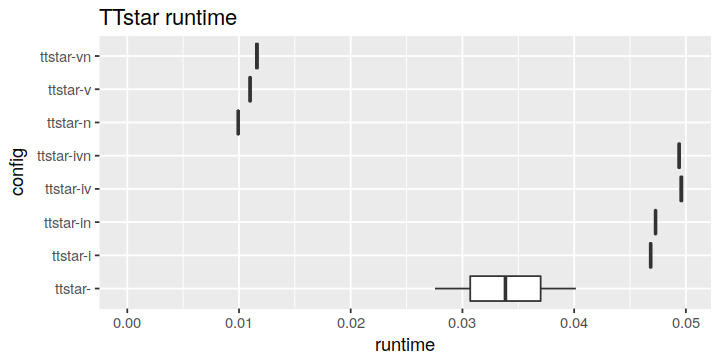

In [34]:
# ttstar
ttstar <- tr[tr$stage == "ttstar",]

options(repr.plot.width=6, repr.plot.height=3)
ggplot(ttstar, aes(x=config, y=runtime)) +
    geom_boxplot() +
    coord_flip() +
    expand_limits(y=0) +
    ggtitle("TTstar runtime")
ggsave('ttstar-runtime.pdf', width=5.6, height=2.6, units='in')

If we run multivariate linear regression, we learn that in this program:
* inference takes **100 ms**
* verification takes **2.2 ms**
* normalisation takes **1.6 ms**
* other overheads (parsing, testing harness, ...) take **9.3 ms**

In [35]:
m <- lm(runtime ~ inference + verification + normalisation, data=ttstar)
summary(m)


Call:
lm(formula = runtime ~ inference + verification + normalisation, 
    data = ttstar)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0065492 -0.0059315 -0.0001535  0.0019483  0.0186375 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.021517   0.003789   5.679 0.000103 ***
inferenceTRUE      0.031690   0.003789   8.364 2.38e-06 ***
verificationTRUE  -0.004080   0.003789  -1.077 0.302790    
normalisationTRUE -0.005768   0.003789  -1.522 0.153847    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007578 on 12 degrees of freedom
Multiple R-squared:  0.8595,	Adjusted R-squared:  0.8244 
F-statistic: 24.48 on 3 and 12 DF,  p-value: 2.112e-05


## Stage: Chicken Scheme compiler

Here we can see that while erasure inference takes **100 ms** itself, it shaves **2 seconds** off code generation.

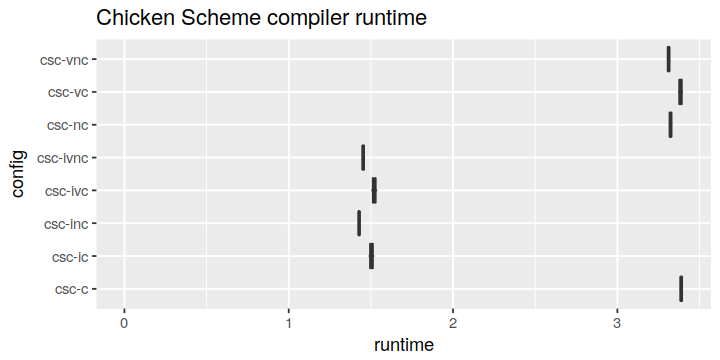

In [36]:
# ttstar
csc <- tr[tr$stage == "csc",]

options(repr.plot.width=6, repr.plot.height=3)
ggplot(csc, aes(x=config, y=runtime)) +
    geom_boxplot() +
    coord_flip() +
    expand_limits(y=0) +
    ggtitle("Chicken Scheme compiler runtime")
ggsave('csc-runtime.pdf', width=5.6, height=2.6, units='in')

In [37]:
m <- lm(runtime ~ inference + verification + normalisation, data=csc)
summary(m)


Call:
lm(formula = runtime ~ inference + verification + normalisation, 
    data = csc)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0217187 -0.0125522  0.0001157  0.0127282  0.0239302 

Coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)        3.383875   0.008210  412.156  < 2e-16 ***
inferenceTRUE     -1.875632   0.008210 -228.452  < 2e-16 ***
verificationTRUE   0.006299   0.008210    0.767    0.458    
normalisationTRUE -0.070049   0.008210   -8.532 1.93e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01642 on 12 degrees of freedom
Multiple R-squared:  0.9998,	Adjusted R-squared:  0.9997 
F-statistic: 1.742e+04 on 3 and 12 DF,  p-value: < 2.2e-16


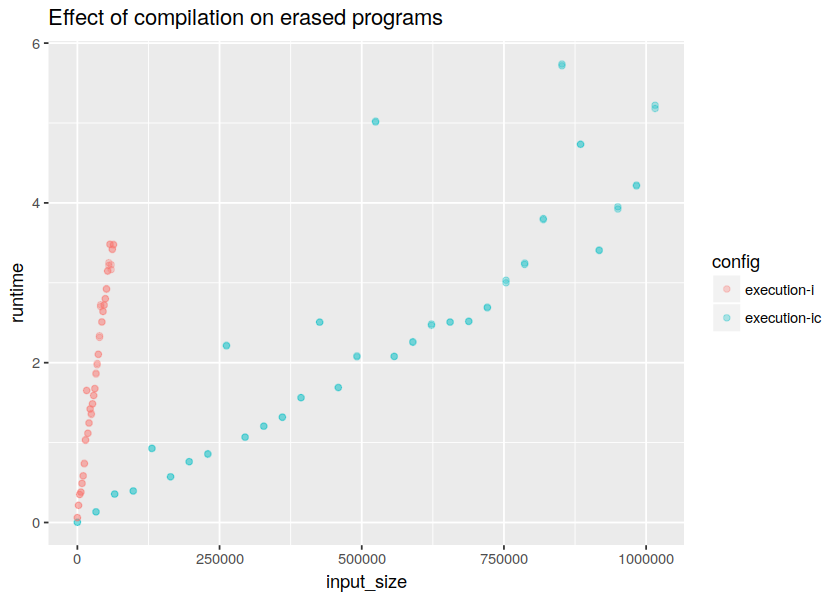

In [38]:
# ttstar
exec <- tr[tr$stage == "execution" & !tr$normalisation & !tr$verification,]

options(repr.plot.width=7, repr.plot.height=5)
ggplot(exec[exec$inference,], aes(x=input_size, y=runtime, color=config)) +
    geom_point(alpha=0.3) +
    ggtitle("Effect of compilation on erased programs")
ggsave('exec-runtime-erased-compilation.pdf', width=2.8, height=2.5, units='in')

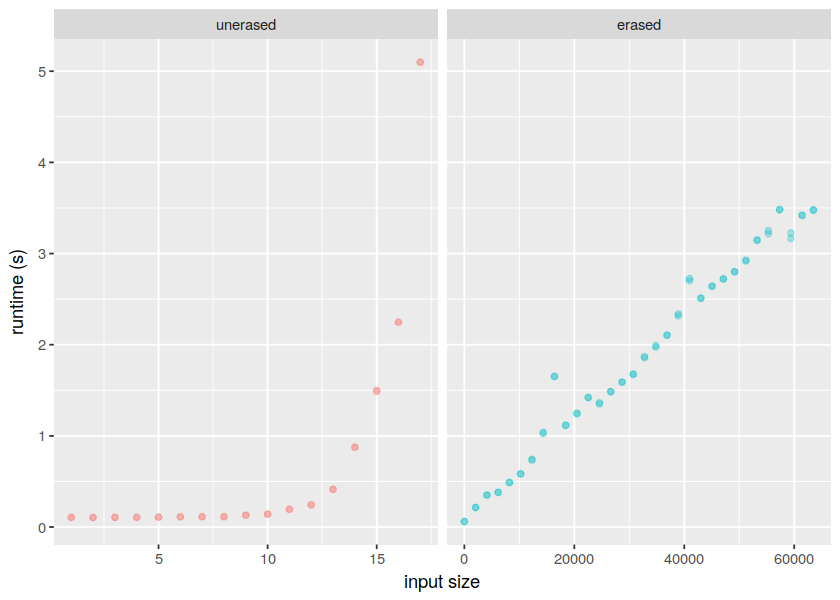

In [39]:
ggplot(exec[!exec$compilation & (exec$runtime < 20.5),], aes(x=input_size, y=runtime, color=config)) +
    geom_point(alpha=0.3) +
    facet_grid(. ~ factor(inference, labels=c('unerased', 'erased')), scales='free_x') +
    xlab('input size') + ylab('runtime (s)') +
    guides(color=F) # remove legend for colour
    #ggtitle("Effect of erasure on interpreted programs")
ggsave('exec-runtime-interpreted-erasure.pdf', width=5.6, height=3.0, units='in')

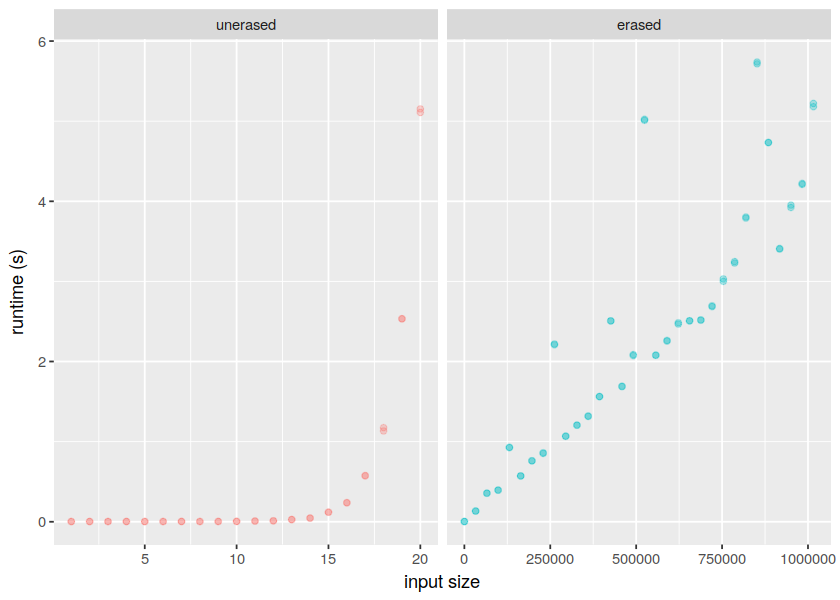

In [40]:
ggplot(exec[exec$compilation,], aes(x=input_size, y=runtime, color=config)) +
    geom_point(alpha=0.3) +
    facet_grid(. ~ factor(inference, labels=c('unerased', 'erased')), scales='free_x') +
    xlab('input size') + ylab('runtime (s)') +
    guides(color=F) # remove legend for colour
    #ggtitle("Effect of erasure on interpreted programs")
ggsave('exec-runtime-compiled-erasure.pdf', width=5.6, height=3.0, units='in')


Call:
lm(formula = log(runtime) ~ log(input_size), data = df)

Residuals:
      805       806 
-0.004351  0.004351 

Coefficients: (1 not defined because of singularities)
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)     1.635295   0.004351   375.9  0.00169 **
log(input_size)       NA         NA      NA       NA   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.006153 on 1 degrees of freedom


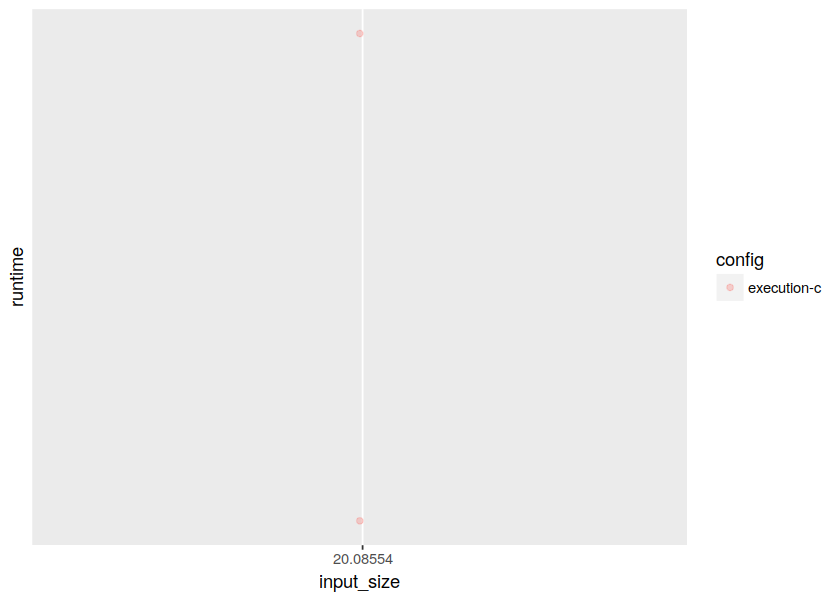

In [41]:
df <- exec[exec$compilation & !exec$inference & (exec$input_size >= 20), c('input_size', 'runtime', 'config')]
ggplot(df, aes(x=input_size, y=runtime, color=config)) +
    geom_point(alpha=0.3) +
    scale_x_continuous(trans='log') +
    scale_y_continuous(trans='log')

m <- lm(log(runtime) ~ log(input_size), data=df)
summary(m)

# again, it's cubic!
# and when erased, it's linear

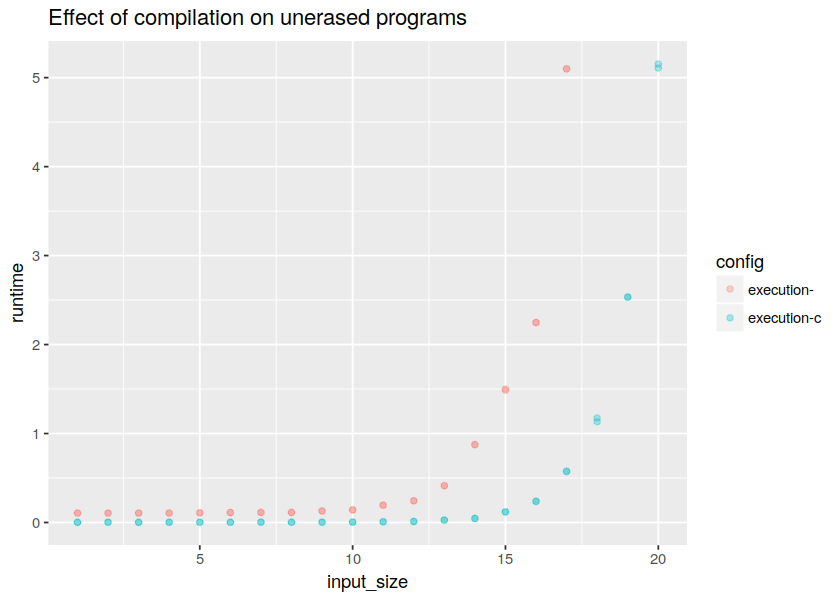

In [42]:
ggplot(exec[!exec$inference,], aes(x=input_size, y=runtime, color=config)) +
    geom_point(alpha=0.3) +
    ggtitle("Effect of compilation on unerased programs")
ggsave('exec-runtime-unerased-compilation.pdf', width=2.8, height=2.5, units='in')

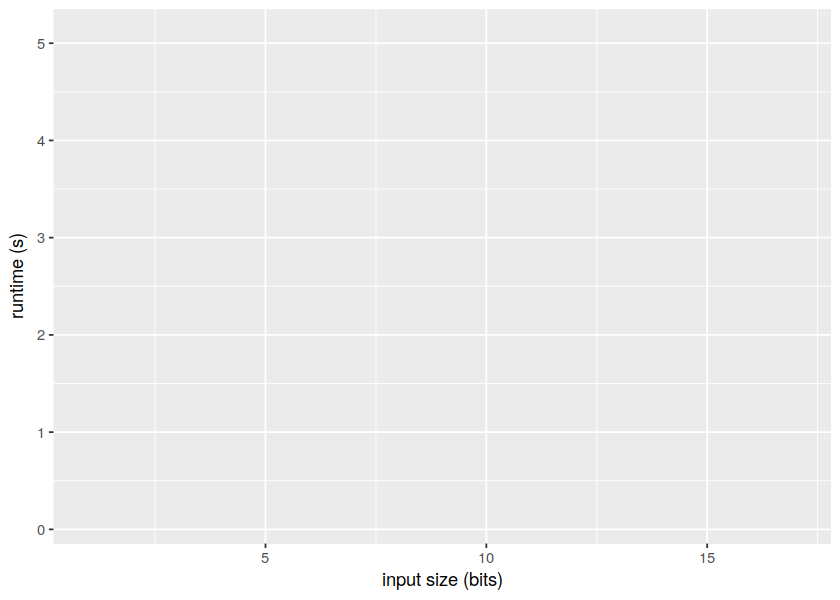

In [43]:
plt <- ggplot(exec[!exec$compilation & !exec$inference,], aes(x=input_size, y=runtime, color=config)) +
    xlab('input size (bits)') + ylab('runtime (s)') +
    guides(color=F) # remove legend for colour
    #ggtitle("Effect of erasure on interpreted programs")
plt
ggsave('talk-blank.pdf', width=5, height=3.2, units='in')

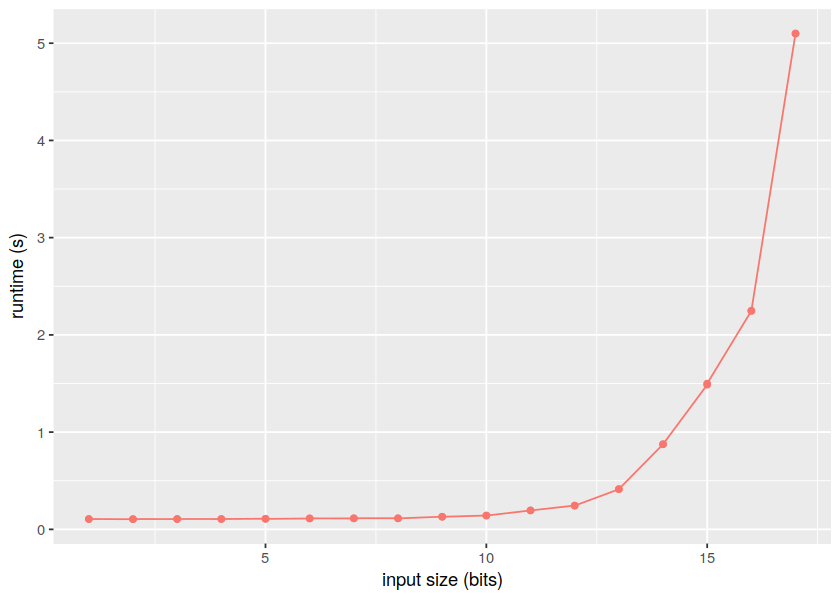

In [45]:
plt + geom_point() + geom_line()
ggsave('talk-unerased.pdf', width=5, height=3.2, units='in')

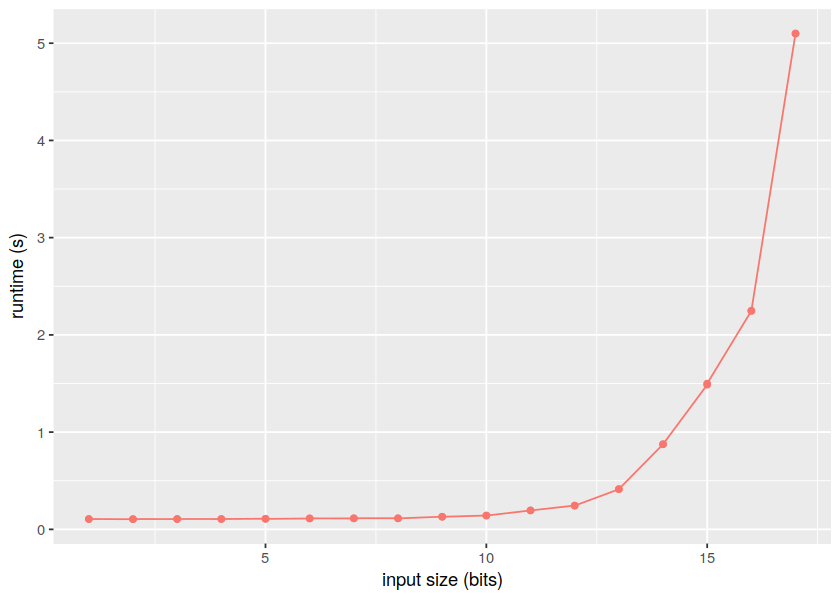

In [46]:
plt <- ggplot(exec[!exec$compilation & exec$inference,], aes(x=input_size, y=runtime, color=config)) +
    geom_point() + geom_line() +
    xlab('input size (bits)') + ylab('runtime (s)') +
    guides(color=F) # remove legend for colour
    #ggtitle("Effect of erasure on interpreted programs")
plt
ggsave('talk-erased.pdf', width=5, height=3.2, units='in')